<a href="https://colab.research.google.com/github/Ark1645/Deep-Learning/blob/main/Cifar10Activation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
pip install utils


  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=0b1db1db4000dafdfe2eda81ee0d561ab206f3ac0157d1c79114abecf35f8324
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from visualize import plotImages, plotHistory, explainGradCam

In [4]:
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal',
                              use_bias=True,
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)


            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)

            return tf.keras.layers.Multiply()([inputs, attention])

In [5]:
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size

        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):

            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)

            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention])

In [6]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete3OVUDW/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete3OVUDW/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [7]:
ds_info

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir=PosixGPath('/tmp/tmpwrk49q9itfds'),
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning mult

In [8]:
ds_info.features['label'].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

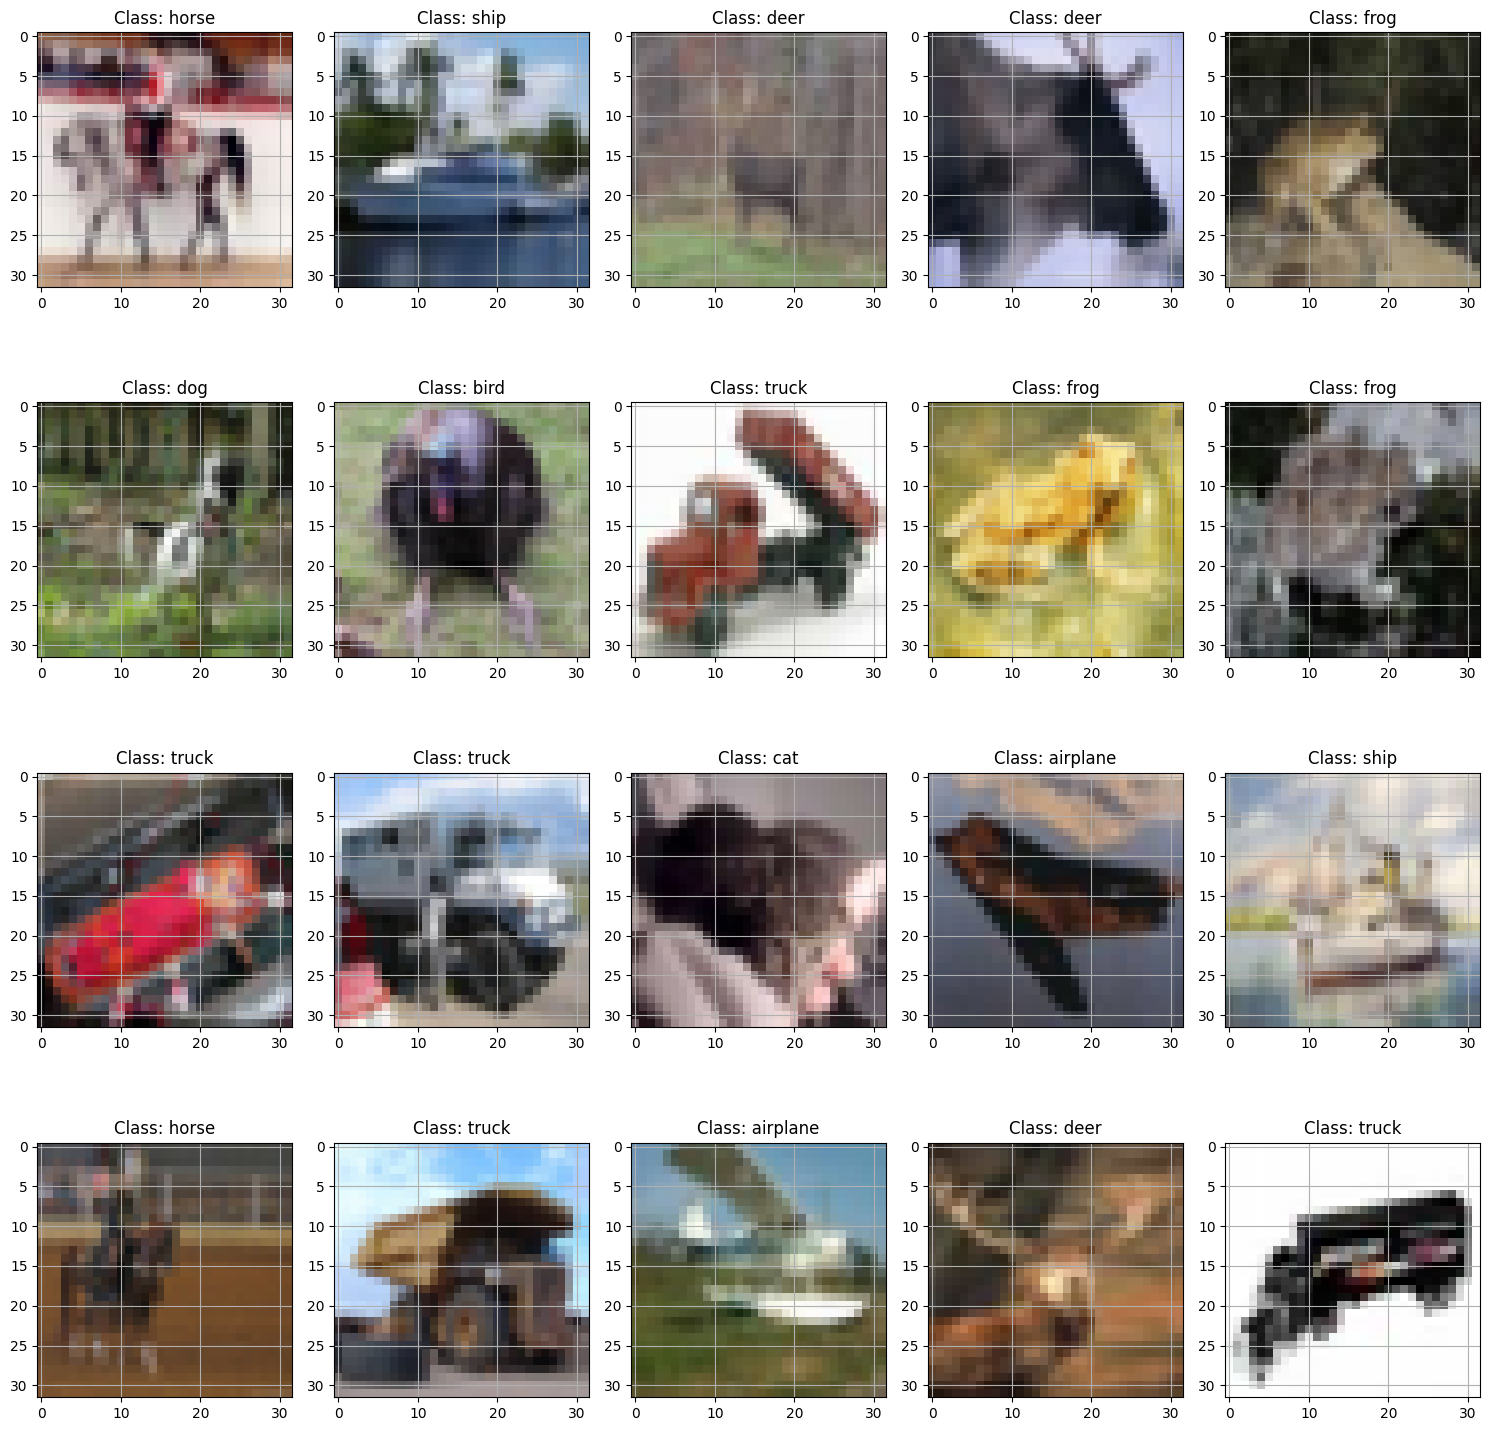

In [9]:
for data in ds_train.batch(20):
    plotImages(data, 20, ds_info.features['label'].names)
    break

In [10]:
def normalize(image, label):
    return tf.cast(image, tf.float32) / 255., label

In [11]:
ds_train = ds_train.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
ds_test = ds_test.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(32)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

NETWORK WITHOUT ATTENTION

In [13]:
simple_cnn_no_attention = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, input_shape=ds_info.features['image'].shape, activation='elu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='elu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax' )
])

In [14]:
simple_cnn_no_attention.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 64)        2

In [15]:
simple_cnn_no_attention.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

In [16]:
history = simple_cnn_no_attention.fit(ds_train, epochs=20)

Epoch 1/20
1563/1563 [==============================] - 25s 7ms/step - loss: 1.1839 - accuracy: 0.5787
Epoch 2/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.7731 - accuracy: 0.7287
Epoch 3/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6191 - accuracy: 0.7864
Epoch 4/20
1563/1563 [==============================] - 10s 7ms/step - loss: 0.5181 - accuracy: 0.8210
Epoch 5/20
1563/1563 [==============================] - 10s 7ms/step - loss: 0.4325 - accuracy: 0.8484
Epoch 6/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.3633 - accuracy: 0.8744
Epoch 7/20
1563/1563 [==============================] - 10s 7ms/step - loss: 0.3037 - accuracy: 0.8935
Epoch 8/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2499 - accuracy: 0.9130
Epoch 9/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2032 - accuracy: 0.9278
Epoch 10/20
1563/1563 [==============================] - 10s 6ms/step - l

NETWORK WITH ATTENTION

In [17]:
simple_cnn_with_attention = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, input_shape=ds_info.features['image'].shape, activation='elu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    ChannelAttention(32, 8),
    SpatialAttention(7),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    ChannelAttention(64, 8),
    SpatialAttention(7),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    ChannelAttention(128, 8),
    SpatialAttention(7),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax' )
])

In [18]:
simple_cnn_with_attention.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_4 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_5 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 channel_attention (Channel  (None, 32, 32, 32)        0         
 Attention)                                                      
                                                      

In [19]:
simple_cnn_with_attention.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

In [20]:
history = simple_cnn_with_attention.fit(ds_train, epochs=20)

Epoch 1/20
1563/1563 [==============================] - 14s 7ms/step - loss: 1.2102 - accuracy: 0.5664
Epoch 2/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.7896 - accuracy: 0.7235
Epoch 3/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6264 - accuracy: 0.7820
Epoch 4/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.5173 - accuracy: 0.8196
Epoch 5/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.4347 - accuracy: 0.8490
Epoch 6/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.3641 - accuracy: 0.8737
Epoch 7/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.3037 - accuracy: 0.8935
Epoch 8/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2478 - accuracy: 0.9124
Epoch 9/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2062 - accuracy: 0.9267
Epoch 10/20
1563/1563 [==============================] - 11s 7ms/step - l

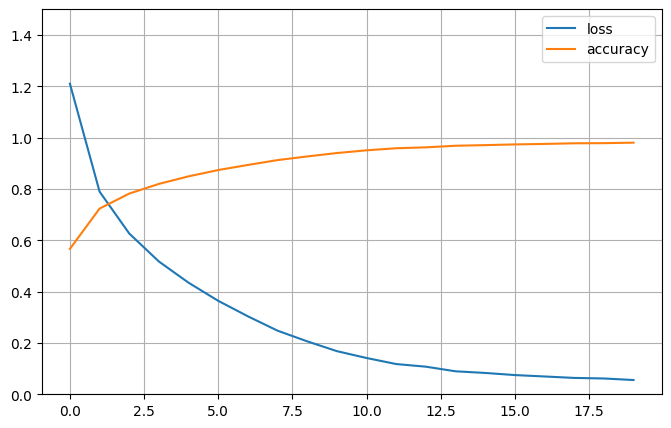

In [21]:
plotHistory(history)

In [22]:
print(f"Test accuracy: {simple_cnn_with_attention.evaluate(ds_test)[1]}")

313/313 [==============================] - 3s 9ms/step - loss: 0.9370 - accuracy: 0.8118
Test accuracy: 0.8118000030517578


VISUALIZE THE NETWORKS

In [27]:
pip install tf-explain


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.4 MB/s eta 0:00:00


In [28]:
from tf_explain.core.grad_cam import GradCAM

In [29]:
explainer = GradCAM()

In [30]:
for images, labels in tfds.as_numpy(ds_test.take(1)):
    X_test = images
    y_test = labels

In [31]:
print(X_test.shape, y_test.shape)

(32, 32, 32, 3) (32,)


NETWORK WITHOUT AND WITH ATTENTION

1/1 [==============================] - 0s 19ms/step


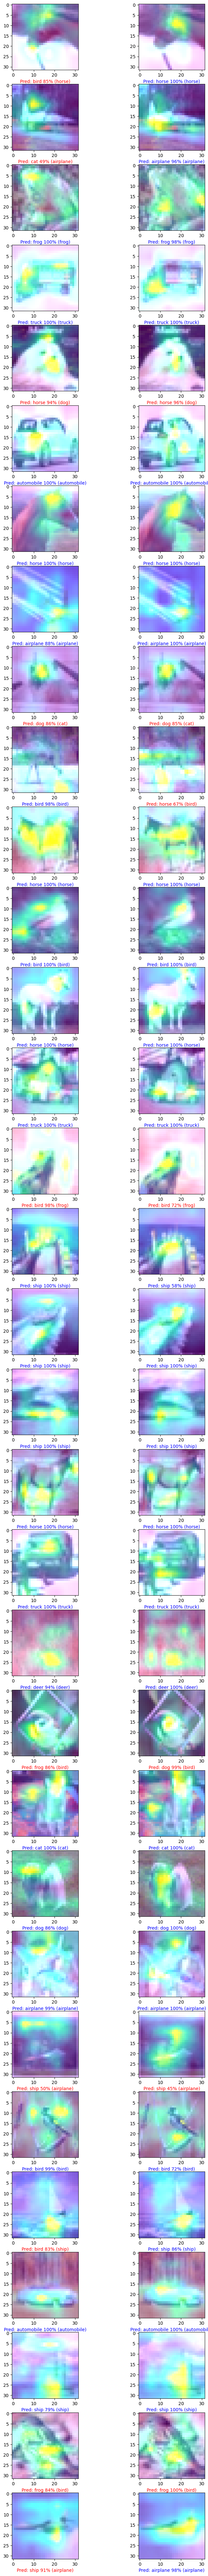

In [32]:
fig, axes = plt.subplots(32, 2, figsize=(8,80))
fig.tight_layout()
index = 0
for img, label in zip(X_test, y_test):
    explainGradCam(explainer, axes[index], img,
               label,
               simple_cnn_no_attention,
               simple_cnn_no_attention.predict(img[None]),
               simple_cnn_with_attention,
               simple_cnn_with_attention.predict(img[None]),
               class_names=ds_info.features['label'].names)
    index += 1